# Ironman triathlon analysis

I have created a web-scraping tool to pull athlete result data from Ironman triathlon events. Using some of this data I'd like to do some simple analysis on the relative distances and finishing times of the three disciplines in triathlon: swim, bike run. In the end, I would like to come up with a 'natural' distance for each disciplines, where each is equally weighted in the event.

## A brief look at finishing times

Using the associated Ironman data-scrapper, the event data for Ironman Canada 2019 (held in Mt. Tremblant) will be used for demonstration. We can see the general structure of the data below. The data pulled from the Ironman site is athlete-specific and quite granular, including all split times and ranks for each individual.

In [15]:
import pandas as pd
import time

event_folder = 'data/canada140/'
ad = pd.read_csv(event_folder+'data.csv')
ad.head()

,link,name,bib,division,age,state,country,profession,points,overall_rank,...,gender_rank,swim_time,bike_time,run_time,total_time,swim_racetime,bike_racetime,run_racetime,t1_time,t2_time
0,https://www.ironman.com/triathlon/events/ameri...,Raynard Picard,139,35-39,39,CA,MEX,---,5000,1.0,...,1.0,3577.0,17389.0,11612.0,32966.0,3577.0,21193.0,32966.0,227.0,161.0
1,https://www.ironman.com/triathlon/events/ameri...,James Curran,211,35-39,34,Munster,IRL,---,4948,2.0,...,2.0,3820.0,17904.0,11172.0,33224.0,3820.0,21907.0,33224.0,183.0,145.0
2,https://www.ironman.com/triathlon/events/ameri...,Reid Foster,130,30-34,33,OK,USA,---,5000,3.0,...,3.0,3437.0,17605.0,11834.0,33242.0,3437.0,21238.0,33242.0,196.0,170.0
3,https://www.ironman.com/triathlon/events/ameri...,Heather Wurtele,3,PRO,40,BC,CAN,---,5000,4.0,...,1.0,3198.0,18107.0,12084.0,33641.0,3198.0,21429.0,33641.0,124.0,128.0
4,https://www.ironman.com/triathlon/events/ameri...,Karel Sumbal,145,40-44,42,SC,CZE,---,5000,5.0,...,4.0,3510.0,19025.0,11043.0,33913.0,3510.0,22730.0,33913.0,195.0,140.0


In [3]:
print('There are {:d} athlete entries.'.format(len(ad.index)))

There are 1489 athlete entries.


Each athlete entry (row) includes a direct link to it's results page, along with detailed race data. All time-based columns are in units of seconds. First, let's look at the finishing times of all the athletes.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.distplot(ad.total_time.dropna())

Notice the irregular distribution shape and the truncation for long time. This is atleast partially due to the hard time limit of the event (17hrs or 61200s). Additionally, each dicipline has it own cut-off time.

In [5]:
print('The average and median total times are ' + time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.mean(ad.total_time))) +
     ' and '+ time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.median(ad.total_time.dropna()))) +
     '. The standard deviation of the distribution is ' +time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.std(ad.total_time))) + '.') 

The average and median total times are 13hrs 21min 41s and 13hrs 23min 51s. The standard deviation of the distribution is 01hrs 46min 57s.


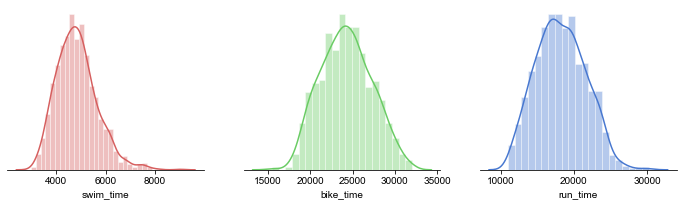

In [6]:
f, ax = plt.subplots(1,3,figsize=(12, 3))
plt.setp(ax, yticks=[])
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)
sns.distplot(ad.swim_time.dropna(), color='r',ax=ax[0])
sns.distplot(ad.bike_time.dropna(), color='g',ax=ax[1])
sns.distplot(ad.run_time.dropna(), color='b',ax=ax[2])

The event cut-off times for the swim, bike, and run are 2hrs 20min (8400s), 8hrs 10min (29400s), and 6hrs 30min (23400s) respectively. Some individual times may exceed this limit, but the athlete would not be permitted to continue to the next dicipline.

In [7]:
print([(np.mean(time), np.median(time.dropna()), np.std(time), np.std(time)/np.mean(time)) for time in [ad.swim_time,ad.bike_time,ad.run_time]])

[(4839.948738812042, 4765.0, 823.7251282290428, 0.17019294473586197), (24268.259509721047, 24194.0, 3001.649341671252, 0.12368622234606039), (18234.61800699301, 18085.5, 3351.7988083726937, 0.18381513706990038)]


An interesting feature of the plots above is that while the swim times produce the narrowest distribution, they are not the least variable with respect to the mean. The swim time standard deviation is 17.0% of the average swim time, compared to 12.4% for the bike, and 18.4% for the run. The run result at least is expected, since it is the last dicipline of a gruelling event. With the body exhausted it is natural to expect significant variability in finishing times.

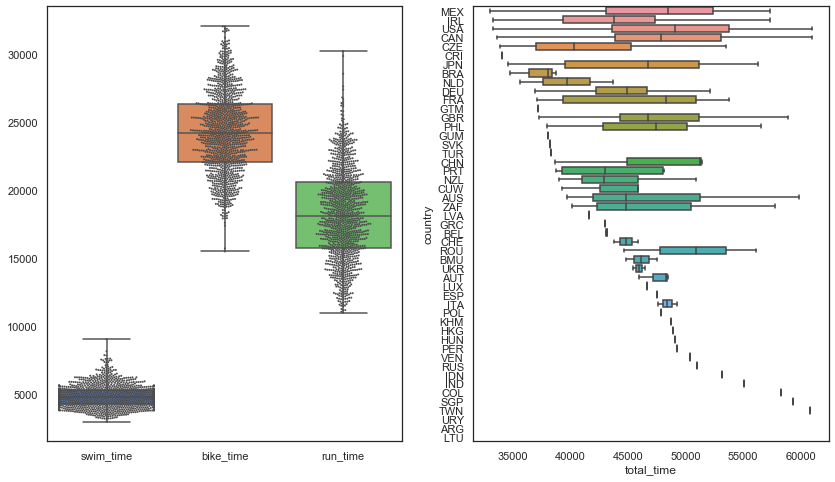

In [8]:
f, ax = plt.subplots(1,2,figsize=(14, 8))
sns.swarmplot(data=ad.iloc[:,12:15],size=2, color=".3", linewidth=0, ax=ax[0])
sns.boxplot(data=ad.iloc[:,12:15], whis="range", ax=ax[0])
sns.boxplot(x='total_time', y='country', data=ad, ax=ax[1])

### A natural triathlon distance

The Ironman triathlon, sometimes referred to as a 140.6, consists of a 3.86km swim, 180.25km bike, and 42.20km run. Added together the event is 226.3km, or 140.6 miles (hence the name). As shown above, the bike portion of the race is heavily weighted, averaging for more than half the total race time. While one could contemplate and debate the merits of this with respect to the sport of triathlon, I am curious what a more evenly weighted race looks like. Presumably there would be less emphasis on the bike, likely being shifted to the swim - but to what extent? 

The total event distance $d_{event}$ is simply the sum of the dicipline distances:
$$
d_{event} = d_{swim} + d_{bike} + d_{run}
$$

In [9]:
d_ims = 3.86; d_imb = 180.25; d_imr = 42.2; d_im = d_ims + d_imb + d_imr

### Weighting schemes for dicipline distances
For the purposes of this analysis we will hold the total event distance constant ($d_{event} = D_T = 226.3 km$). This leaves us to choose conditions for the weighting of each dicipline. We will investigate a few weighting schemes now. In each case, the dicipline distance is characterized by it weight, $W_i$:
$$
d_i = W_iD_{T}
$$
The weights must be normalized, therefore:
$$
\sum W_i = 1
$$

#### Equal weighting
A simple scheme is to simply weight all diciplines equally:
$$
W_i = \frac{1}{N} = \frac{1}{3}.
$$
The resulting dicipline distance is $226.3/3 = 75.4 km$. 

In [10]:
w_s = w_b = w_r = 1/3
print('The dicipline distances are swim = {:.1f}km, bike = {:.1f}km, run = {:.1f}km.'.format(*[w*d_im for w in [w_s,w_b,w_r]]))

The dicipline distances are swim = 75.4km, bike = 75.4km, run = 75.4km.


This is a trivially absurd example considering a 'marathon' swim is typically expressed as $10 km$, i.e. the event would consist of 8 consecutive marathon swim, capped by two marathon runs. Meanwhile, the bike distance is nothing a a casual Sunday rider couldn't handle. While this example is silly, it does suggest the next weighting scheme: time-weighted distances.

#### Time weighting
Time (or speed) weighting may be the first 'natural' choice for determining dicipline distances. The premise is that each dicipline should take roughly the same amount of time to complete. On an individual basis this almost certainly will not hold true, but if instead we consider the entire field we can determine a weighting scheme that will satisfy the equal-time criterion.

Once again, we are using the Ironman Canada 2019 data as a test-case. The mean split swim/bike/run times in this event were:

In [20]:
print('{:.2f}, {:.2f}, {:.2f} hours, respectively.'.format(*[np.mean(time)/(60*60) for time in [ad.swim_time,ad.bike_time,ad.run_time]]))

1.34, 6.74, 5.07 hours, respectively.


The average split time for each dicipline is given simply by $t_i = \frac{d_i}{v_i}$, where $v_i$ is the average speed for the split. Since $d_i = W_i D_{T}$, the split time can be written as:
$$
t_i = \frac{W_i}{v_i}D_T
$$
and the dicipline weights written as:
$$
W_i = \frac{v_i t_i}{D_T}.
$$

If we enforce the condition that split times must be equal, $t_i = t_{swim} = t_{bike} = t_{run} = T$, then we see that, since $T$ and $D_T$ are constant, the weights are proportional to the average speed.

We can express the normalized weights, $W_i$, in a slightly different manner:
$$
W_i = \frac{w_i}{\sum w_i},
$$
where $w_i$ are unnormalized and the sum in the denominator serves as the normalization constant. Using this notation it is simple to see that in the case of equal-time weighting, $w_i=v_i$, and so:
$$
W_i = \frac{1}{\sum v_i}v_i.
$$
Evidently, the normalization constant is $\frac{1}{\sum v_i}=\frac{T}{D_T} = A$.

The average swim, bike, and run speeds (from IronmanCanada 2019) are:

In [54]:
v = np.array([(x*1000)/(np.mean(time)) for (x,time) in zip([d_ims,d_imb,d_imr],[ad.swim_time,ad.bike_time,ad.run_time])])
print('{:.2f}, {:.2f}, {:.2f} m/s, respectively.'.format(*v))

0.80, 7.43, 2.31 m/s, respectively.


In [59]:
A = 1/np.sum(v)
W = A*v
d = d_im*W
print('Normalization A: {:.3f} s/m'.format(A))
print('Weights:\n\tSwim: {:.3f}\n\tBike: {:.3f}\n\tRun: {:.3f}'.format(*W))
print('Distances: {} km total\n\tSwim: {:.2f} km\n\tBike: {:.2f} km\n\tRun: {:.2f} km'.format(d_im,*d))
print('Total average time: {:.1f} hrs'.format(3*(A*1000)*d_im/(60*60)))

Normalization A: 0.095 s/m
Weights:
	Swim: 0.076
	Bike: 0.705
	Run: 0.220
Distances: 226.31 km total
	Swim: 17.13 km
	Bike: 159.49 km
	Run: 49.69 km
Total average time: 17.9 hrs


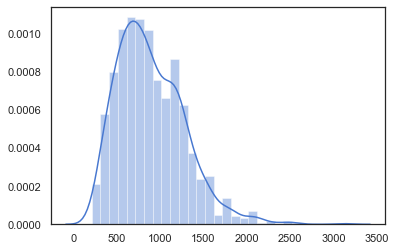

In [11]:
sns.distplot((ad.t1_time+ad.t2_time).dropna())

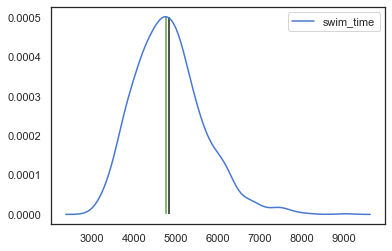

In [12]:
data = ad.swim_time.dropna()
kde = sns.kdeplot(data)
x,y = kde.get_lines()[0].get_data()
imax = np.argmax(y)
plt.vlines([x[imax],np.mean(data),np.median(data)],0,np.max(y), color=['r','k','g'])